#### Question 2 with SA

---
#### Some Hyperparmeteres

In [7]:
# Hyperparameters
NO_UPDATE_TIMES = 10e4 #10e4
POPULATION_SIZE = 10
MAXIMUM_WEIGHT = 529    #529
NUMBER_OF_PAIRS_OF_MULTI_BIT_FLIP = 3
CROSSOVER_PROBABILITY = 0.1
ITERATIONS = 20
EACH_TYPE_ONE_ELEMENT = 0 #False

#### Load Data

In [8]:
import pandas as pd
List_of_Gear = pd.read_csv('List_of_gear.csv')

# Setup Row & Weapon name mapping
df = List_of_Gear.iloc[:,0]

# Setup Weight & Survival Points mapping
Weight_Map = List_of_Gear.iloc[:,2].to_numpy()
Survival_Points_Map = List_of_Gear.iloc[:,3].to_numpy()

---
#### 2(c) Methods for GA

In [9]:
import numpy as np

def Weight_Mapping(Given_Array):
    Sum_of_weight = 0
    for i in range(len(Given_Array)):
        if Given_Array[i] == 1:
            Sum_of_weight += Weight_Map[i]
    return Sum_of_weight

def Survival_Points_Mapping(Given_Array):
    Sum_of_Survival_Points = 0
    for i in range(len(Given_Array)):
        if Given_Array[i] == 1:
            Sum_of_Survival_Points += Survival_Points_Map[i]
    # Extra Points
        ## YG1265 or Krieg 500 + Desert Eagle + tactical shield, survival points +25
    if(((Given_Array[7]==1)|(Given_Array[10]==1))&(Given_Array[5]==Given_Array[14]==1)):
        Sum_of_Survival_Points += 25
        ## shadow dagger + desert eagle, survival points +5
    if(Given_Array[0]==Given_Array[5]==1):
        Sum_of_Survival_Points += 5
        ## 228 Compact + AK-47 or M4A1, survival points +15
    if(((Given_Array[8]==1)|(Given_Array[9]==1))&(Given_Array[3]==1)):
        Sum_of_Survival_Points += 15
        ## Carry all three equipments, survial points +70
    if(Given_Array[12]==Given_Array[13]==Given_Array[14]==1):
        Sum_of_Survival_Points += 70
    return Sum_of_Survival_Points

def Check_Overweight(Given_Array):
    Weight = Weight_Mapping(Given_Array)
    if (Weight <= MAXIMUM_WEIGHT):
        return 0
    else:
        #print(f'Overweight!, weight={Weight}')
        return 1

def Check_Inventory_Requirement(Given_Array):
    Copy_with_padding = np.pad(Given_Array,
                               (0, 15-len(Given_Array)),
                               'constant',
                               constant_values=0)
    if((sum(Copy_with_padding[0:3])>0)
            &(sum(Copy_with_padding[3:6])>0)
            &(sum(Copy_with_padding[12:15])>0)):
        return 1
    else:
        return 0

def Return_Cobinations_of_Additional_Survival_Points(Given_Array):
    Sum_of_Survival_Points = 0
    for i in range(len(Given_Array)):
        if Given_Array[i] == 1:
            Sum_of_Survival_Points += Survival_Points_Map[i]
    # Extra Points
        ## YG1265 or Krieg 500 + Desert Eagle + tactical shield, survival points +25
    if(((Given_Array[7]==1)|(Given_Array[10]==1))&(Given_Array[5]==Given_Array[14]==1)):
        print(f'YG1265 or Krieg 500 + Desert Eagle + tactical shield')
        Sum_of_Survival_Points += 25
        ## shadow dagger + desert eagle, survival points +5
    if(Given_Array[0]==Given_Array[5]==1):
        print(f'shadow dagger + desert eagle')
        Sum_of_Survival_Points += 5
        ## 228 Compact + AK-47 or M4A1, survival points +15
    if(((Given_Array[8]==1)|(Given_Array[9]==1))&(Given_Array[3]==1)):
        print(f'228 Compact + AK-47 or M4A1')
        Sum_of_Survival_Points += 15
        ## Carry all three equipments, survial points +70
    if(Given_Array[12]==Given_Array[13]==Given_Array[14]==1):
        print(f'Carry all three equipments')
        Sum_of_Survival_Points += 70
    return Sum_of_Survival_Points

def Randomly_Select_A_Row_from_Matrix(Given_Matrix):
    number_of_rows = Given_Matrix.shape[0]
    random_indicies = np.random.choice(number_of_rows, size=1, replace=False)
    Selected_Row = Given_Matrix[random_indicies, :]
    Selected_Row = np.squeeze(Selected_Row)
    return Selected_Row

def Generate_Single_Creature(Each_Type_One_Element):

    # The goal of the following part is to constraint the inventory bag to \
    # \"one item in each type" settings. However, it seems that\
    # \this settings were not required, thus the part was aborted.

    # if(Each_Type_One_Element==1):
    # # Except equipments, we can only choose one item in each type.
    # # I will set the initial choice of each items by utilizing np.eye matrix,\
    # # \then randomly select a row in order to represent the collection of items chosen.
    #     Knife = np.eye(3, dtype=int); Pistols = np.eye(3, dtype=int); Primary = np.eye(6, dtype=int);
    #     Selected_Knife = Randomly_Select_A_Row_from_Matrix(Knife)
    #     Selected_Pistols = Randomly_Select_A_Row_from_Matrix(Pistols)
    #     Selected_Primary = Randomly_Select_A_Row_from_Matrix(Primary)
    #     Equipments = np.random.randint(2, size=3, dtype=int)
    #     Items_in_Bag = np.concatenate((Selected_Knife, Selected_Pistols, Selected_Primary, Equipments))

    # else:
    Items_in_Bag = np.random.randint(2, size=15)

    # Conforming to the inventory bag settings of 'carry at least one knife,\
    # \one pistol and one equipment.
    while(Check_Inventory_Requirement(Items_in_Bag)==0):
        Items_in_Bag = np.random.randint(2, size=15)

    if Check_Overweight(Items_in_Bag)==0:
        return Items_in_Bag
    else:
        return Generate_Single_Creature(Each_Type_One_Element)   #Recursive Call till no overweight

def Generate_Population(Each_Type_One_Element):
    Population = []
    for i  in range(POPULATION_SIZE):
        Single_Creature = Generate_Single_Creature(Each_Type_One_Element)
        #Single_Creature = np.array(Single_Creature)
        Population.append(Single_Creature)
    #print(f'Population successfully created.')
    #print(f'Population shape:{np.array(Population).shape}')
    return Population

def Roulete_Wheel_Selection(Given_Matrix):

    A = []
    max = -np.inf
    for i in range(len(Given_Matrix)):
        survial_point = Survival_Points_Mapping(Given_Matrix[i])
        A.append(survial_point)
        if survial_point > max:
            max = survial_point
    #print(f'A:{A}')
    #print(f'max:{max}')

    sum = 0
    for j in range(len(Given_Matrix)):
        #sum = sum + np.max([1,max-A[j]])
        sum += A[j]
        A[j] = sum
    #print(A)

    Matepool = []
    for k in range(int(len(Given_Matrix)/2)):
        a = np.random.randint(sum)
        #print(f'a:{a}')
        i=0
        while(a>A[i]):
            i += 1
        Matepool.append(Given_Matrix[i])
    #print(f'Matepool:\n{Matepool}')
    #print(f'shape of Matepool: {np.array(Matepool).shape}')

    return Matepool

def Uniform_Crossover(Given_Matrix):
    Test_Matrix = Given_Matrix
    for i in range(int(len(Test_Matrix)/2)):

        for j in range(int(len(Test_Matrix[i]))):
            a = np.random.uniform(0,1,1)
            if a >= CROSSOVER_PROBABILITY:
                # SWAP the elements among two weapons lists.
                Test_Matrix[2*i][j], Test_Matrix[2*i+1][j] = Test_Matrix[2*i+1][j], Test_Matrix[2*i][j]

    number_of_weapon_lists_overweight = 0

    # Check any of the weapon lists are overweight
    for i in range(int(len(Test_Matrix))):
        number_of_weapon_lists_overweight += Check_Overweight(Test_Matrix[i])

    if number_of_weapon_lists_overweight == 0:
        return Test_Matrix
    else:
        return Uniform_Crossover(Given_Matrix)
        #If there is an weapon lists exceed pack weight constraint, \
        # \then we'll do the Uniform_Crossover step again.

def Multi_Bit_Flip_Mutation(Given_Matrix, Number_of_Pairs_of_Multi_Bit_Flip):
    Test_Matrix = Given_Matrix
    # Doubling the population size in the step\
    # \to make the amount of creatures fixed in each generations.
    Test_Matrix = np.concatenate((Test_Matrix, Test_Matrix))

    #
    for i in range(int(len(Test_Matrix)/2)):
        for j in range(Number_of_Pairs_of_Multi_Bit_Flip):
            interchange_location = np.random.randint(int(len(Test_Matrix[i])),size=2)
            Test_Matrix[i][interchange_location[0]], Test_Matrix[i][interchange_location[1]] =\
            Test_Matrix[i][interchange_location[1]], Test_Matrix[i][interchange_location[0]]

    number_of_weapon_lists_overweight = 0

    # Check any of the weapon lists are overweight
    for i in range(int(len(Test_Matrix))):
        number_of_weapon_lists_overweight += Check_Overweight(Test_Matrix[i])

    if number_of_weapon_lists_overweight == 0:
        return Test_Matrix
    else:
        return Multi_Bit_Flip_Mutation(Given_Matrix, NUMBER_OF_PAIRS_OF_MULTI_BIT_FLIP)
        #If there is an weapon lists exceed pack weight constraint, \
        # \then we'll do the "Multi_Bit_Flip_Mutation" step again.

def Get_the_Best_Combination(Given_Matrix, print_result):
    max = -np.inf
    for i in range(len(Given_Matrix)):
        if Survival_Points_Mapping(Given_Matrix[i]) > max:
            max = Survival_Points_Mapping(Given_Matrix[i])
            best_combination = Given_Matrix[i]

    if (print_result):
        print(f'   The best combination in the current generation is: {best_combination}'
              f'\n    with maximum survival points: {max}'
              f', and total weight: {Weight_Mapping(best_combination):.1f}')
    return max, best_combination
    #return 0

#### Let's Start

In [10]:
GA = []
max_SP_over_all_generation = -np.inf
Population = Generate_Population(Each_Type_One_Element=EACH_TYPE_ONE_ELEMENT)

for iters in range(ITERATIONS):
    #print(f'\n===== Generation: {iters+1} =====')
    Selected_Creatures = Roulete_Wheel_Selection(Population)
    Syngamy = Uniform_Crossover(Selected_Creatures)
    Next_Generation = Multi_Bit_Flip_Mutation(Syngamy,
                                              NUMBER_OF_PAIRS_OF_MULTI_BIT_FLIP)
    Population = Next_Generation
    max_SP_of_current_generation,\
    best_combination_of_current_generation = Get_the_Best_Combination(Next_Generation,
                                                                      print_result=0)

    if (max_SP_of_current_generation > max_SP_over_all_generation):
        best_combination_over_all_generation = best_combination_of_current_generation
        max_SP_over_all_generation = max_SP_of_current_generation
    #for population_size in range(POPULATION_SIZE):
    GA.append(max_SP_over_all_generation)

print(f'   The best combination over all generations is: {best_combination_over_all_generation}'
      f'\n    with corresponding items: ', end=" ")
for i in range(len(best_combination_over_all_generation)):
    if best_combination_over_all_generation[i] == 1:
        print(f'{df[i]} +', end=" ")
print(f'\n    and maximum survival points: {max_SP_over_all_generation}'
        f', total weight: {Weight_Mapping(best_combination_over_all_generation):.1f}')

#print(best_combination_over_all_generation)
#x = Return_Cobinations_of_Additional_Survival_Points(best_combination_over_all_generation)

   The best combination over all generations is: [1 0 1 1 0 0 1 0 1 0 1 0 1 0 0]
    with corresponding items:  Shadow_Daggers + Gut_Knife + 228_Compact_Handgun + Ingram_MAC-10_SMG + M4A1_Carbine + Krieg_550_Sniper_Rifles + Gas_Mask + 
    and maximum survival points: 832, total weight: 526.6


In [11]:
# Generate Initial Temperature
rand_4pts = []
for i in range(4):
    Creature = Generate_Single_Creature(Each_Type_One_Element=0)
    rand_4pts.append(Survival_Points_Mapping(Creature))

init_temp = np.average(rand_4pts)

# Set Initial Weapons List
x = Generate_Single_Creature(Each_Type_One_Element=0)
SA = []

## Some Initializations
n = 2 # iterations
c = 0.5 # temperature reduction factor
no_update_times = 0
des_x = x
temp = init_temp
iters_sum = 0

while(no_update_times<=NO_UPDATE_TIMES):

    iter = 0

    while((iter<=n)&(no_update_times<=NO_UPDATE_TIMES)):
        # Compute current_state
        current_state = Survival_Points_Mapping(des_x)

        r = Generate_Single_Creature(Each_Type_One_Element=0)
        attempt_state = Survival_Points_Mapping(r)

        # Step 3 and Step 4
        del_f = attempt_state - current_state

        if del_f>0:
            #print(f'del_f:{del_f}')
            c = np.random.uniform(0, 1, 1)
            Prob_of_X_2 = np.exp(-del_f/(1*temp))
            #print(f' r = {r} , $P(X_2)$ = {Prob_of_X_2}')
            if Prob_of_X_2 > c:
                des_x = r
                #print(f'! assign new design (x) = {des_x}')
                SA.append(float(Survival_Points_Mapping(r)))
                current_state = attempt_state
                temp = c*temp
                no_update_times = 0
        else:
            no_update_times +=1

        iter += 1
        iters_sum += 1

print(f'   The best combination over all generations is: {des_x}'
      f'\n    with corresponding items: ', end=" ")
for i in range(len(des_x)):
    if des_x[i] == 1:
        print(f'{df[i]} +', end=" ")
print(f'\n    and maximum survival points: {current_state}'
        f', total weight: {Weight_Mapping(des_x):.1f}')

   The best combination over all generations is: [1 1 1 0 0 1 0 1 1 1 0 0 0 0 1]
    with corresponding items:  Shadow_Daggers + Huntsman_Knife + Gut_Knife + Desert_Eagle_Magnum + Leone_YG1265_Auto_Shotgun + M4A1_Carbine + AK-47_Rifle + Tactical_Shield + 
    and maximum survival points: 797, total weight: 500.4


#### FE plot

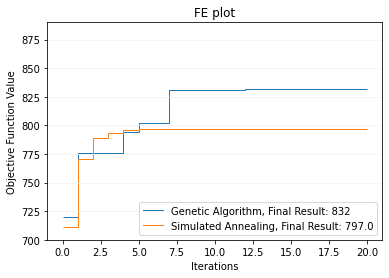

In [18]:
for i in range(20-len(SA)):
    SA.append(SA[-1])

import matplotlib.pyplot as plt
plt.stairs(GA, label=f'Genetic Algorithm, Final Result: {GA[-1]}', baseline=None)
plt.stairs(SA, label=f'Simulated Annealing, Final Result: {SA[-1]}', baseline=None)

plt.xlabel('Iterations')
plt.ylabel('Objective Function Value')
plt.title('FE plot')
# plt.xlim()
plt.ylim((700,890))
plt.grid(axis='y', color='0.95')

plt.legend(loc=4)

plt.show()